# Simulated Cube: Motion Extraction & Material-Property Estimation
This demo walks through motion extraction and material-property inference for a simulated cube. The following files are needed:
* For motion extraction and mode identification: `simulated_data/{OBJ_NAME}/{SIM_NAME}.gif` (could be other video format besides GIF)
* For comparison to ground truth: `simulated_data/{OBJ_NAME}/true_stiffness.npy`, `simulated_data/{OBJ_NAME}/true_density.npy`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib import cm

import vvt
# from utils import (read_frames, extract_motion, weighted_gaussian_smooth,
#                    get_fft_results, find_peak_idxs, prompt_clicks,
#                    get_cube_model, keypoints_from_clicks, gather_image_space_modes,
#                    get_observed_modal_data, get_solver)
# from utils import (plot_motion_field, find_nearest, normalize_modes,
#                    interpolate_2d_motion, freqs_to_eigvals, projection_matrix_from_keypoints,
#                    full_mode_matrix, weighted_sum, project_and_interpolate_motion,
#                    plot_3d_cube)

In [3]:
OBJ_NAME = 'defect00'
SIM_NAME = 'top_front_pluck'
FPS = 2000

N_THREADS = 8  # num. threads to use in multithreaded functions

## Motion Extraction

In [4]:
"""
Read input video.
"""
video_fn = 'simulated_data/%s/%s_%s.gif' % (OBJ_NAME, OBJ_NAME, SIM_NAME)
video_frames = vvt.motion.read_frames(video_fn)

Reading frames: 100%|██████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:13<00:00, 878.52it/s]


In [5]:
"""
Extract horizontal and vertical displacement fields,
and then apply amplitude-weighted Gaussian smoothing.
This step may take a couple minutes.
`motion_fields` has the shape (2, T, H, W), where 
`motion_fields[0]` contains the horizontal displacement fields,
and `motion_fields[1]` contains the vertical displacement fields.
"""
t_start, t_end = 50, 6000  # range of frames to extract motion for
reference_frame = video_frames[t_start]
motion_fields = vvt.motion.extract_motion(
    video_frames[t_start:t_end], reference_frame, n_threads=N_THREADS)
motion_fields = vvt.motion.weighted_gaussian_smooth(
    motion_fields, reference_frame, sigma=4, n_threads=N_THREADS)

Running motion extraction in 8 threads...
[Thread 0] 100 / 118 frames processed in 19.9 seconds.
Done! Elapsed time: 0:00:23.908162
Running amplitude-weighted Gaussian smoothing in 8 threads...
Done! Elapsed time: 0:00:02.342548


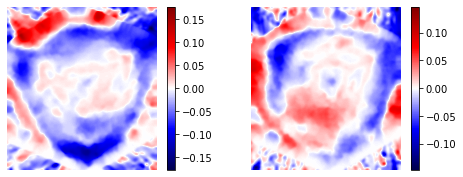

In [7]:
"""
View the displacement field at one frame.
"""
t = 10
plt.figure(figsize=(8, 3))
plt.subplot(121)
vvt.vis.plot_motion_field(motion_fields[0][t])

plt.subplot(122)
vvt.vis.plot_motion_field(motion_fields[1][t])

## Mode Identification

In [8]:
"""
Run 1D FFT on displacement fields.
`fft_dx[i]` contains the FFT coefficients of horizontal motion at FFT bin i.
`fft_dy[i]` contains the FFT coefficients of vertical motion at FFT bin i.
`spectrum` is the power spectrum of horizontal + vertical motion amplitude.
`ffreqs[i]` is the frequency [Hz] of FFT bin i.
"""
max_fft_freq = 50  # max. frequency (in Hz) to consider
fft_dx, fft_dy, spectrum, ffreqs = vvt.modes.get_fft_results(
    motion_fields, FPS, max_fft_freq, n_threads=N_THREADS)
log_spectrum = np.log(spectrum)

Running FFT in 8 threads...
[Thread 0] 5 / 51 rows processed in 0.3 seconds.
[Thread 0] 10 / 51 rows processed in 0.4 seconds.
[Thread 0] 15 / 51 rows processed in 0.4 seconds.
[Thread 0] 20 / 51 rows processed in 0.4 seconds.
[Thread 0] 25 / 51 rows processed in 0.4 seconds.
[Thread 0] 30 / 51 rows processed in 0.4 seconds.
[Thread 0] 35 / 51 rows processed in 0.4 seconds.
[Thread 0] 40 / 51 rows processed in 0.4 seconds.
[Thread 0] 45 / 51 rows processed in 0.4 seconds.
[Thread 0] 50 / 51 rows processed in 0.4 seconds.
Done! Elapsed time: 0:00:03.882137


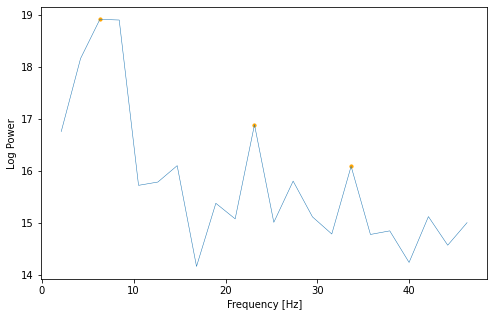

In [9]:
"""
Find peaks in the log-power spectrum of motion amplitude.
"""
max_fft_idx = vvt.utils.find_nearest(ffreqs, max_fft_freq)

# If undamped, recommended prominence is 0.05.
# If damped, recommended prominence is 0.01.
prominence = 0.05
peak_idxs = vvt.modes.find_peak_idxs(log_spectrum[:max_fft_idx], prominence=prominence)

plt.figure(figsize=(8, 5))
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(
    ffreqs[peak_idxs], log_spectrum[peak_idxs],
    color='orange', label='Peaks', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')
plt.show()

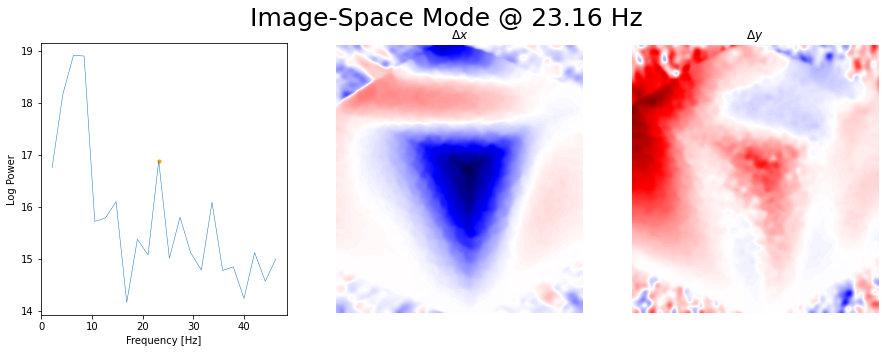

In [10]:
"""
View a specified image-space mode.
"""
fft_idx = peak_idxs[1]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
vvt.vis.plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta$$x$')
plt.axis('off')

plt.subplot(133)
vvt.vis.plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta$$y$')
plt.axis('off')
plt.show()

## Inference

In [11]:
"""
Define an inference cube model, with specific dimensions, voxel resolution,
homogeneous Poisson's ratio, and mesh element order.
"""
XLEN, YLEN, ZLEN = 0.05, 0.05, 0.05  # dimensions of the cube, in meters
NX, NY, NZ = 8, 8, 8                 # num. voxels in each direction
NU = 0.3                             # homogeneous Poisson's ratio
DEGREE = 1                           # mesh element order (a.k.a. degree)
N_VOX = NX * NY * NZ

cube = vvt.cube.get_cube_model(XLEN, YLEN, ZLEN, NX, NY, NZ, NU, DEGREE)

Element mass mats: 100%|███████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:04<00:00, 103.71it/s]


### Locate keypoints (i.e., visible mesh vertices) in the image

<IPython.core.display.Javascript object>


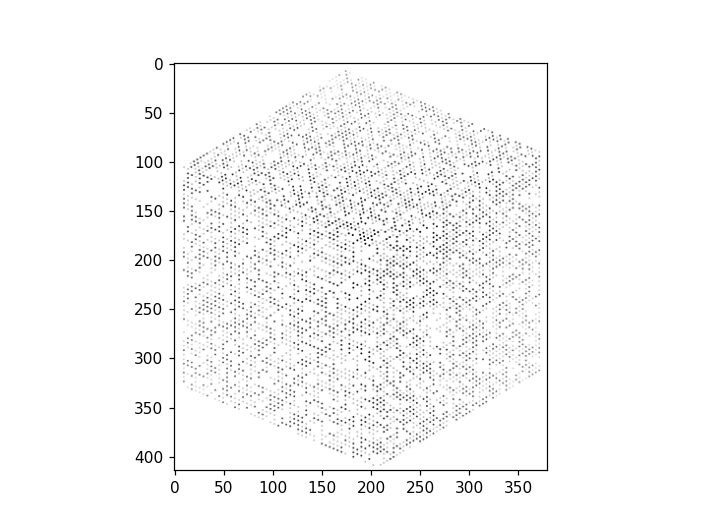

In [14]:
"""
Get the pixel locations of reference mesh points (i.e., the 7 visible corners).
Click the following points in the exact order:
1. bottom left
2. bottom middle
3. bottom right
4. top left back
5. top left front
6. top right back
7. top right front
"""
%matplotlib notebook
clicks = []
vvt.utils.prompt_clicks(reference_frame, clicks, cmap='gray')

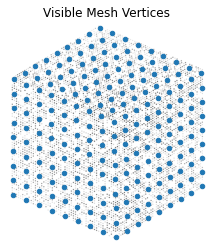

In [15]:
plt.close('all')
%matplotlib inline
keypoints = vvt.utils.keypoints_from_clicks(clicks, NX, NY, NZ)

plt.imshow(reference_frame, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20)
plt.axis('off')
plt.title('Visible Mesh Vertices')
plt.show()

In [17]:
"""
Sample image-space modes at keypoints (i.e., visible mesh vertices).
`U_observed` is the full mode matrix, in which only the visible DOFs are
set to the observed (projected) mode shape. Its boundary DOFs are set to 0,
and we normalize each mode to have norm 1.
"""
image_space_modes_dx, image_space_modes_dy = vvt.modes.gather_image_space_modes(
    fft_dx, fft_dy, peak_idxs)
U_observed = vvt.modes.get_observed_modal_data(
    image_space_modes_dx, image_space_modes_dy,
    keypoints, cube.n_dofs, cube.image_space_dofs)
U_observed[cube.bc_dofs] = 0
U_observed = vvt.modes.normalize_modes(U_observed)
freqs_observed = ffreqs[peak_idxs]
eigvals_observed = vvt.utils.freqs_to_eigvals(freqs_observed)

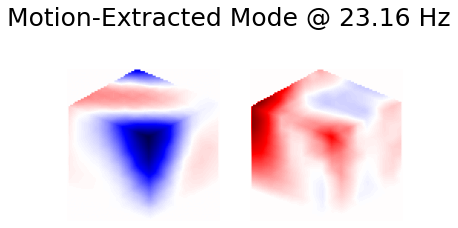

In [19]:
"""
View a specific image-space mode as interpolated between keypoints.
"""
mode_idx = 1
mode_freq = freqs_observed[mode_idx]
mode_2d = U_observed[cube.image_space_dofs, mode_idx].reshape(-1, 3)[:, :2]
mode_dx, mode_dy = vvt.motion.interpolate_2d_motion(keypoints, mode_2d)

fig = plt.figure()
fig.suptitle(
    'Motion-Extracted Mode @ %.2f Hz' % mode_freq,
    fontsize=25)
plt.subplot(121)
vvt.vis.plot_motion_field(mode_dx, cbar=False)

plt.subplot(122)
vvt.vis.plot_motion_field(mode_dy, cbar=False)
plt.show()

In [22]:
"""
Initialize Solver and set the modal data used for material-property estimation.
"""
proj_mat = vvt.utils.projection_matrix_from_keypoints(cube, keypoints)
solver = vvt.solver.get_solver(cube, proj_mat)

U_input = U_observed[cube.nonbc_dofs]
eigvals_input = eigvals_observed
solver.update_observations(U_input, eigvals_input)
n_modes = solver.k

AttributeError: module 'vvt' has no attribute 'utils'

### Run solver

In [ ]:
"""
Set the hyperparameters of the optimization problem that is solved
to estimate the material properties.
"""
w_init = 9000  # initial homog. Young's modulus (in Pa)
v_init = 1270  # initial homog. density (in kg/m3)
eta = 1        # dual-variable update rate
norm_converge_thresh = 1e-3
solver.params['alpha_u'] = 10 if n_modes >= 10 else 1
solver.params['alpha_w'] = 1e-10 / N_VOX
solver.params['alpha_v'] = 1e-7 / N_VOX
solver.params['alpha_e'] = 1
solver.params['scale_reg_type'] = 'mean'
solver.params['alpha_w_mean'] = 1
solver.params['alpha_v_mean'] = 0
solver.params['w_mean'] = w_init
solver.params['v_mean'] = v_init

In [ ]:
"""
Run the iterative optimization algorithm, plotting the progress
at each step.
"""
initialize = True

if initialize:
    Ut = solver.Uo.copy()
    evalst = solver.evals_observed.copy()
    wt = np.ones(n_vox) * w_init
    vt = np.ones(n_vox) * v_init
    Kt = vvt.utils.weighted_sum(solver.element_stiffness_mats, wt)
    Mt = vvt.utils.weighted_sum(solver.element_mass_mats, vt)
    dual_vars = np.ones(solver.k)
    
    losses_dict = {
        'total': [],
        'constr': [],
        'constr_unw': [],
        'data': [],
        'eigval_data': [],
        'tsv_w': [],
        'tsv_v': [],
        'scale_reg': []
    }
    
Uo_full = vvt.utils.full_mode_matrix(solver.Uo, cube.n_dofs, cube.nonbc_dofs)
w_prev, v_prev = wt, vt
start_t = len(losses_dict['total'])
for t in range(start_t, start_t + 100):
    iter_start = time.time()
    
    # Solve modes.
    Ut = solver.solve_U(Kt, Mt, evalst, dual_vars)
    
    # Solve eigenvalues.
    evalst = solver.solve_evals(Kt, Mt, Ut, dual_vars)
    
    # Update dual variables.
    dual_vars = solver.update_dual_vars(Kt, Mt, Ut, evalst, dual_vars, eta)
    
    # Solve material properties.
    wv = solver.solve_w_v(
        Ut, evalst, dual_vars,enforce_pos=True)
    wt = wv[:solver.n_weights]
    vt = wv[solver.n_weights:]
    Kt = vvt.utils.weighted_sum(solver.element_stiffness_mats, wt)
    Mt = vvt.utils.weighted_sum(solver.element_mass_mats, vt)
    
    # Update losses.
    unw_loss_dict, loss_dict = solver.loss(Ut, evalst, Kt, Mt, wt, vt, dual_vars)
    for loss_term in loss_dict.keys():
        losses_dict[loss_term].append(loss_dict[loss_term])
    losses_dict['constr_unw'].append(unw_loss_dict['constr'])
        
    # Check solution convergence.
    w_residual = wt - w_prev
    v_residual = vt - v_prev
    w_residual_norm = np.linalg.norm(w_residual) / np.linalg.norm(w_prev)
    v_residual_norm = np.linalg.norm(v_residual) / np.linalg.norm(v_prev)
    if w_residual_norm <= norm_converge_thresh and v_residual_norm <= norm_converge_thresh:
        print('Converged! (w residual norm = %.6f, v residual norm = %.6f)'
              % (w_residual_norm, v_residual_norm))
        break
    w_prev, v_prev = wt, vt
    
    # Plot progress.
    Ut_full = vvt.utils.full_mode_matrix(Ut, cube.n_dofs, cube.nonbc_dofs)
    Ut_proj = solver.P @ Ut
    
    fig = plt.figure(figsize=(12, 20))
    
    plt.subplot(621)
    cube.plot_2d(wt, cmap='inferno')
    plt.axis('off')
    plt.title("Estimated stiffness ($t=%d$)" % (t+1))
    
    plt.subplot(622)
    cube.plot_2d(vt, cmap='viridis')
    plt.axis('off')
    plt.title("Estimated density ($t=%d$)" % (t+1))
    
    # Plot losses.
    plt.subplot(623)
    plt.plot(np.log(losses_dict['total']))
    plt.title('Log Total Loss')
    
    plt.subplot(624)
    plt.plot(losses_dict['constr'])
    plt.title('Constraint Loss')
    
    plt.subplot(625)
    plt.plot(np.log(losses_dict['tsv_w']))
    plt.title('Log TSV ($w$)')
    
    plt.subplot(626)
    plt.plot(np.log(losses_dict['tsv_v']))
    plt.title('Log TSV ($v$)')
    
    plt.subplot(627)
    plt.plot(dual_vars, linewidth=0.5)
    plt.scatter(np.arange(solver.k), dual_vars)
    plt.title('Dual Variables')
    
    ax = fig.add_subplot(6, 2, 8)
    ax.plot(np.log(losses_dict['data']))
    ax.set_title('Log Data Loss')

    # Visualize random mode.
    i = np.random.randint(0, solver.k)
    
    # Estimated mode:
    est_mode_3d = Ut_full[cube.image_space_dofs, i].reshape(-1, 3)
    est_mode_dx, est_mode_dy = project_and_interpolate_motion(
        keypoints, est_mode_3d, proj_mat)
    
    ax = fig.add_subplot(6, 4, 17)
    vvt.vis.plot_motion_field(est_mode_dx, fig=fig, ax=ax, cbar=False)
    ax.set_title('Est. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 18)
    vvt.vis.plot_motion_field(est_mode_dy, fig=fig, ax=ax, cbar=False)
    ax.set_title('Est. $\Delta$$y$')
    
    # Observed mode:
    obs_mode_2d = Uo_full[cube.image_space_dofs, i].reshape(-1, 3)[:, :2]
    obs_mode_dx, obs_mode_dy = vvt.motion.interpolate_2d_motion(
        keypoints, obs_mode_2d)
    
    ax = fig.add_subplot(6, 4, 19)
    vvt.vis.plot_motion_field(obs_mode_dx, fig=fig, ax=ax, cbar=False)
    ax.set_title('Obs. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 20)
    vvt.vis.plot_motion_field(obs_mode_dy, fig=fig, ax=ax, cbar=False)
    ax.set_title('Obs. $\Delta$$y$')
    
    # 1d mode comparison:
    ax = fig.add_subplot(6, 2, 11)
    ax.plot(solver.Uo[:, i], alpha=0.7, label='Observed')
    ax.plot(Ut_proj[:, i], alpha=0.7, label='Estimated')
    ax.legend()
    ax.set_title('Mode %d' % i)
    
    # 3d mode:
    ax = fig.add_subplot(6, 2, 12)
    ax.plot(Ut[:,i] / np.linalg.norm(Ut[:,i]))
    ax.set_title('3D Mode %d' % i)
    
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(plt.gcf())
    plt.close('all')
    
    print('[t=%03d] %.3f sec, w residual norm: %.6f, v residual norm: %.6f'
          % (t, time.time() - iter_start, w_residual_norm, v_residual_norm))

### Compare results to the true material properties

In [ ]:
# Forward model uses a 10x10x10 hexahedral mesh.
cube_forward = get_cube_model(XLEN, YLEN, ZLEN, 10, 10, 10, NU, ELEMENT_ORDER)

# Load true properties.
true_w = np.load('simulated_data/%s/true_stiffness.npy' % OBJ_NAME)
true_v = np.load('simulated_data/%s/true_density.npy' % OBJ_NAME)

In [ ]:
fig = plt.figure(figsize=(6, 20))

pad_height = 1
elev = 20
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("Estimated Young's Modulus")
plot_3d_cube(cube, wt, cmap=cm.inferno, pad_height=pad_height, elev=elev, fig=fig, ax=ax)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("Estimated Density")
plot_3d_cube(cube, vt, cmap=cm.viridis, pad_height=pad_height, elev=elev, fig=fig, ax=ax)
plt.show()

In [ ]:
fig = plt.figure(figsize=(4, 20))

pad_height = 7
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("True Young's Modulus")
plot_3d_cube(cube_forward, true_w, cmap=cm.inferno, pad_height=pad_height, fig=fig, ax=ax)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("True Density")
plot_3d_cube(cube_forward, true_v, cmap=cm.viridis, pad_height=pad_height, fig=fig, ax=ax)
plt.show()